# Networks of types of organisations


Experimental, do not consider !

In [ ]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd


import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [ ]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [ ]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [ ]:
print(reload(naf))  

## Get the data from the triplestore

This notebook is based on the same relationships (and therefore data) as [the one about persons' relationships](wdt_persons_organisations_networks.ipynb), namely the relationship between persons and organisation as original information.

...  [compléter]


In [ ]:
## define SPARQL enpoint
endpoint = "https://ag16gm9pr0meths2.allegrograph.cloud/repositories/astronomers"

In [ ]:
query = """

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>


SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
        ?relationship 
        ?organisation (MIN(?oLabel) AS ?organisationLabel)
        (COUNT(*) as ?n) 
        (GROUP_CONCAT(DISTINCT ?groupTypeLabel; separator=" | ") AS ?groupTypes) 
        #(GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 

WHERE {
        GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
        {
        {?person a wd:Q5;
           rdfs:label ?pLabel;
           wdt:P569 ?birthYear.
        }


        {?person wdt:P108 ?organisation.
        BIND('employment' AS ?relationship)
        }   
        UNION
        {?person wdt:P463 ?organisation.
        BIND('membership' AS ?relationship)
        }   
        UNION
        {?person wdt:P69 ?organisation.
        BIND('education' AS ?relationship)
        }  
        ?organisation rdfs:label ?oLabel;
                # instance of
                wdt:P31 ?groupType.
        ?groupType rdfs:label ?groupTypeLabel         
        
        # OPTIONAL {
        #    ?organisation wdt:P17 ?country.
        #    ?country rdfs:label ?countryLabel.
        # }

         }        



    }

GROUP BY ?person ?relationship ?organisation   
ORDER by ?person 
"""

In [26]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


78224
[['http://www.wikidata.org/entity/Q100406890',
  'Yuichi Ikeda',
  '1961',
  'employment',
  'http://www.wikidata.org/entity/Q336264',
  'Kyoto University',
  '4',
  'national university | comprehensive university | academic publisher | '
  'university'],
 ['http://www.wikidata.org/entity/Q100414958',
  'Ian Elliott',
  '1936',
  'education',
  'http://www.wikidata.org/entity/Q258464',
  'Trinity College Dublin',
  '2',
  'collegiate university | nonprofit organization'],
 ['http://www.wikidata.org/entity/Q1004177',
  'Pál Fröhlich',
  '1889',
  'membership',
  'http://www.wikidata.org/entity/Q265058',
  'Hungarian Academy of Sciences',
  '4',
  'köztestület | academy of sciences | national academy | organization']]


## Inspect the data


In [27]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesOrg']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


Number:  78224


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg
10,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q270222,Michigan State University,3,land-grant university | public research univer...
11,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,education,http://www.wikidata.org/entity/Q219563,University of Washington,1,public university
12,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,education,http://www.wikidata.org/entity/Q153265,University of Cincinnati,3,public university | research university | publ...


### Distribution of relationships in relation to birthYears of organisations members

In [ ]:
l_50 = list(range(1751, 2051, 50))
print(l_50)

In [28]:
### We adapt the periods manually,
# we would like to have eight periods
# making sense from an historical point of view 
lc = [1751, 1801, 1851, 1901, 1921, 1941, 1961, 1981, 2001]

In [29]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [32]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods
1,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,education,http://www.wikidata.org/entity/Q153978,University of Tübingen,6,public university | comprehensive university |...,1921-1940
5,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,membership,http://www.wikidata.org/entity/Q1636237,Royal Danish Academy of Sciences and Letters,1,academy of sciences,1851-1900
10,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q270222,Michigan State University,3,land-grant university | public research univer...,1921-1940


In [33]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

periods
1751-1800     2030
1801-1850     4127
1851-1900    10668
1901-1920    10585
1921-1940    18688
1941-1960    19368
1961-1980    10344
1981-2000     2414
dtype: int64


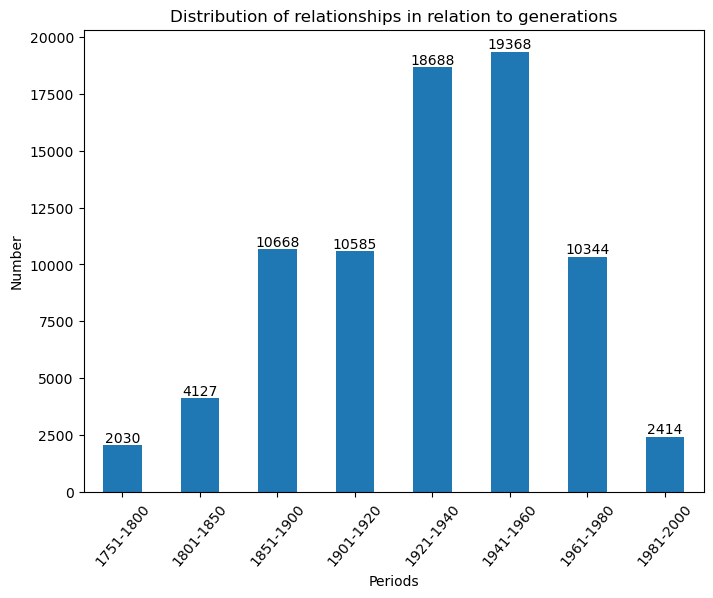

In [34]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of relationships in relation to generations')
plt.show()

### Add education period

In [35]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     29294
employment    31537
membership    17393
dtype: int64


In [53]:
### Add constructed education period
df_p['BeginY'] = df_p[df_p.relaType=='education'].birthYear.apply(lambda x : x + 18)
df_p['EndY'] = df_p[df_p.relaType=='education'].birthYear.apply(lambda x : x + 29)
df_p.iloc[5:9]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,BeginY,EndY,listTypesOrg,listTokensTypesOrg
5,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,membership,http://www.wikidata.org/entity/Q1636237,Royal Danish Academy of Sciences and Letters,1,academy of sciences,1851-1900,NaN,NaN,[academy of sciences],"[academy, sciences]"
6,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,education,http://www.wikidata.org/entity/Q3436286,Odense University,1,university,1851-1900,1910.0,1921.0,[university],[university]
7,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q1499258,United States Naval Research Laboratory,2,military unit | research institute,1921-1940,NaN,NaN,"[military unit, research institute]","[institute, military, research, unit]"
8,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q1410332,National University of Lesotho,1,public university,1921-1940,NaN,NaN,[public university],"[public, university]"


### Clean up organisations type

In [52]:
### Transform types' strings to alphabetically sorted lists and delete additional white spaces
df_p['listTypesOrg'] = df_p.typesOrg.apply(lambda x : sorted([e.strip().lower() for e in x.split('|')]))

ll = df_p.listTypesOrg.to_list()
print(len(ll))
pprint.pprint(ll[:3])


78224
[['academy of sciences', 'building'],
 ['comprehensive university',
  'open-access publisher',
  'organization',
  'public research university',
  'public university',
  'university of excellence'],
 ['academy of sciences', 'learned society', 'national academy']]


In [39]:
## Rebuild the sorted original texts
df_p['typesOrg'] = df_p.listTypesOrg.apply(lambda x : ' | '.join(x))
df_p.iloc[[1,5,10]]


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,BeginY,EndY,listTypesOrg,listTokensTypesOrg
1,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,education,http://www.wikidata.org/entity/Q153978,University of Tübingen,6,comprehensive university | open-access publish...,1921-1940,1947.0,1958.0,"[comprehensive university, open-access publish...","[comprehensive, excellence, open-access, organ..."
5,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,membership,http://www.wikidata.org/entity/Q1636237,Royal Danish Academy of Sciences and Letters,1,academy of sciences,1851-1900,NaN,NaN,[academy of sciences],"[academy, sciences]"
10,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q270222,Michigan State University,3,land-grant university | public educational ins...,1921-1940,NaN,NaN,"[land-grant university, public educational ins...","[educational, institution, land-grant, public,..."


In [57]:
print(df_p.groupby('typesOrg').size().sort_values(ascending=False).iloc[:10])

typesOrg
university                                                                                                     2960
public university                                                                                              2420
academy of sciences                                                                                            1583
research institute                                                                                             1527
international organization | scientific organization                                                           1455
open-access publisher | public university                                                                      1432
open-access publisher | university                                                                             1401
academic publisher | learned society | nonprofit organization                                                  1321
academic publisher | academy of sciences | production company |

#### Save dataframe to CSV

In [58]:
file_add = 'data/persons_organisations.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

In [59]:
### load from CSV

file_add = 'data/persons_organisations.csv'
df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

78224


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,BeginY,EndY,listTypesOrg
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,membership,http://www.wikidata.org/entity/Q833738,Heidelberg Academy for Sciences and Humanities,2,academy of sciences | building,1921-1940,NaN,NaN,"['academy of sciences', 'building']"
1,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,education,http://www.wikidata.org/entity/Q153978,University of Tübingen,6,comprehensive university | open-access publish...,1921-1940,1947.0,1958.0,"['comprehensive university', 'open-access publ..."


## Types of organisations

Property **wdt:P31 instance of**

We try to figure out if we can use these types to sort out and distinguish the organisations

In [76]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby('typesOrg').size().sort_values(ascending=False))
df_types.reset_index(inplace=True)
df_types.columns=['typesOrg', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
df_types.iloc[:10]

,typesOrg,number,numberOrg
0,university,2960,1
1,public university,2420,1
2,academy of sciences,1583,1
3,research institute,1527,1
4,international organization | scientific organi...,1455,2
5,open-access publisher | public university,1432,2
6,open-access publisher | university,1401,2
7,academic publisher | learned society | nonprof...,1321,3
8,academic publisher | academy of sciences | pro...,1295,4
9,academy of sciences | learned society | nation...,1152,6


In [77]:
### Print to CSV in order to inspect the data
csv_file='files/network_organisations_types_groups.csv'
df_types.to_csv(csv_file)

### Create a graph of the organisations' types

In [ ]:
ltt = [a for b in df_p.listTypesO.to_list() for a in b]
print(len(ltt))

In [ ]:
ls = pd.Series(ltt)
ls_df = pd.DataFrame(ls.groupby(by=ls).size().sort_values(ascending=False))
ls_df.reset_index(inplace=True)
ls_df.columns=['orgType', 'number']
print(ls_df.head()) 
print(ls_df.tail())


In [ ]:
### Distribution of number of types per organisation
freq_s = pd.Series([len(e) for e in df_p['listTypesO'].to_list()])
print(freq_s.describe())

In [ ]:
## Distribution of types (with minimum value)
print(ls_df[ls_df.number > 10].number.describe())

In [ ]:
csv_file='files/network_organisations_types.csv'
ls_df.to_csv(csv_file)

In [ ]:
ld = ls_df[ls_df.number > 10].to_dict(orient='records', index=True)
print(ld[:2])


In [ ]:
l = [tuple(
    (e['orgType'],
     {'number':e['number']}
     )) 
     for e in ls_df.to_dict(orient='records')]
print(len(l), l[:2])

In [ ]:
G = nx.Graph()
G.add_nodes_from(l)
print(list(G.nodes.data())[:2])

In [ ]:
### Prepare import
fl = [e for e in df_p['listTypesO'].to_dict().items()]
print(fl[:3])

In [ ]:
### List of distinct organisation types with more than 10 representatives
so = list(set(ls_df[ls_df.number > 10].orgType.to_list()))
print(len(so), so[:3])

In [ ]:
table_l = []
for a in fl:
    if len(a[1]) > 1:
        for b in a[1]:
            if b in so:
                table_l.append((a[0], b))
print(table_l[:5])

In [ ]:
table_df = pd.DataFrame(table_l, columns=['org_id', 'org_type'])
print(len(table_df))
table_df.head()

In [ ]:
### Join on common organisation -> produces a lot of rows !
merged = pd.merge(table_df, table_df, on=['org_id'])
print(len(merged))
merged.head()


In [ ]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['org_type_x'] < (merged['org_type_y'])]
print(len(merged))
merged.head()

In [ ]:
gb_merged = pd.DataFrame(merged.groupby(by=['org_type_x', 'org_type_y']).size())
gb_merged.reset_index(inplace=True)
gb_merged.columns=['org_type_x', 'org_type_y', 'number']
gb_merged.iloc[100:120, ]

In [ ]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['org_type_x'], e['org_type_y'],
     {'number':e['number']}
     )) 
     for e in gb_merged.to_dict(orient='records')]
print(len(l), l[:2])

In [ ]:
G.add_edges_from(l)

### Explore graph and it's components

In [ ]:
naf.basic_graph_properties(G)

In [ ]:
### Create a list of graphs, one per component
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True)
print(len (ln))
print(ln[:5])

In [ ]:
print(S[1].nodes.data())

In [ ]:
naf.basic_graph_properties(S[0])

In [ ]:
print(list(S[0].nodes.data())[:3])
print(list(S[0].edges.data())[:3])

In [ ]:
### Plot the graph

g = S[0]

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 2
sc = 1

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['number'] for n in g.nodes.data()]
node_labels = dict([tuple(( n[0] , n[0] ))for n in g.nodes.data()])
edge_size = [np.log(n[2]['number']) if n[2]['number'] > 300
             else 0  for n in g.edges.data()]
font_weight= dict([tuple(( n[0] , 'bold' if n[1]['number'] > 100
                            else 'normal' ))
                    for n in g.nodes.data()])

nx.draw_networkx_nodes(g, pos, node_color='#86B2E4' , node_size=node_size, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, font_color='#5B3210', font_weight=font_weight, alpha=0.7, font_size=14)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
plt.savefig('images/organisations_types_network_big_component.svg')
plt.close()


In [ ]:
### All the rest of the small separate components
li = [e[0] for e in ln[1:]]
pG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    pG = nx.union(pG, S[i])
print(bipartite.is_bipartite(pG))   
naf.basic_graph_properties(pG)

In [ ]:
### Plot the graph

g = pG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'kamada_kawai'
n_k = 2
sc = 1

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['number']*50 for n in g.nodes.data()]
node_labels = dict([tuple(( n[0] , n[0] ))for n in g.nodes.data()])
edge_size = [np.log(n[2]['number']) if n[2]['number'] > 1
             else 0  for n in g.edges.data()]
font_weight= dict([tuple(( n[0] , 'bold' if n[1]['number'] > 10
                            else 'normal' ))
                    for n in g.nodes.data()])

nx.draw_networkx_nodes(g, pos, node_color='#86B2E4' , node_size=node_size, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, font_color='#5B3210', font_weight=font_weight, alpha=0.7, font_size=14)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
plt.savefig('images/organisations_types_network_small_components.svg')
plt.close()
